### Predicting MSFT Stock Price Inefficiencies

It would be easier to know whether or not you should buy MSFT stock options if it was possible to predict if MSFT is *undervalued*, *overvalued*, *efficient* or *volatile*, specifically:

Undervalued, if at a given time if before the end of the following week it sustains a price 3% higher for at least 2 days 

Overvalued, if at a given time if before the end of the following week it sustains a price 3% lower for at least 2 days  

Efficient, if it's not undervalued or overvalued

Volatile, if it's undervalued and overvalued

This information would be helpful for option trading strategies because contracts are priced as premiums above a strike price and so if it can be deduced that the strike price plus the premium is still less than what the price is assessed to be at, the value of the contract can be predicted to be undervalued and so purchased and hopefully realized profitably. 

**Requirements**

In [81]:
# silencing future warnings 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gmean
from math import sqrt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split


**Reading in the Features**

The data folder contains a file MSFT.csv with timeseries MSFT stock market trading data.

In [83]:
df0 = pd.read_csv('../data/alpha/MSFT.csv', 
                 parse_dates=['time'], 
                 index_col='time')

# number of records in original range
n_original = len(df0[(df0.index > '2021-1-1')&(df0.index< '2022-7-1')])
print()
print('records in original range', n_original)
print('minutes in a year and a half', 60*24*365*1.5)
print()
print(df0.head(3))
print()



records in original range 231171
minutes in a year and a half 788400.0

                     Unnamed: 0    open    high     low   close  volume
time                                                                   
2022-10-20 20:00:00           0  235.40  235.40  234.75  234.75    1926
2022-10-20 19:56:00           1  234.75  234.80  234.75  234.80    3119
2022-10-20 19:55:00           2  234.75  234.75  234.75  234.75    1109



**Downsampling**

As seen above the index has gaps, only about 30% is filled. The frequency rate can be changed to adjust this. The frequency can be optimized by maximizing frequency rate while minimizing NaN rate. 

This is done by calculating the distance from the point 0,0 on the frequency-nan rate axis, which represents the maximal resolution sample with no missing values. 

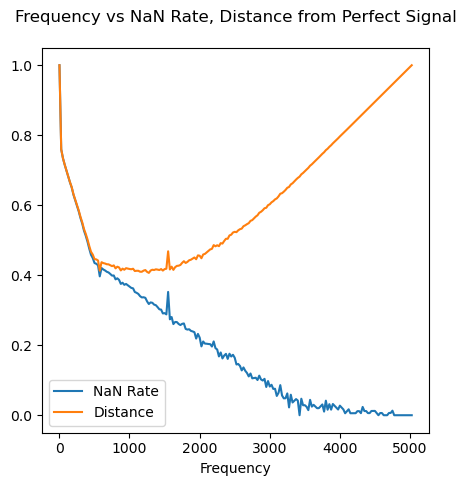

In [84]:
column_funcs = {'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'}

# print(df.head())

def na_rate(df):
    return df['high'].isnull().sum()/len(df)

freqs_vals = [1 + i for i in range(5040)][::25]
freqs = [str(freq_val) + "T" for freq_val in freqs_vals]
freqs_labels = [str(i) + "T" for i in range(5040)][::25]

na_rates = [na_rate(df0.resample(freq).agg(column_funcs))
          for freq in freqs]

df1 = pd.DataFrame(data=zip(freqs_vals, na_rates),
                   columns=['Frequency', 'NaN Rate'])

f_max = max(freqs_vals)
r_max = max(na_rates)

df1['norm_freq'] = [f/f_max for f in freqs_vals]
df1['NaN Rate'] = [r/r_max for r in na_rates]
df1['Distance'] = np.linalg.norm(df1[['norm_freq','NaN Rate']], axis=1)

plt.figure(figsize=[5,5])
ax= plt.subplot(111)
df1.plot(x='Frequency', y='NaN Rate', ax=ax)
df1.plot(x='Frequency', y='Distance', title='Frequency vs NaN Rate, Distance from Perfect Signal\n', ax=ax)
plt.savefig('../figures/freq_nan_distance.png')
plt.show()



The optimum frequency is printed and the dataset is resampled accordingly.

In [85]:
print('Optimum Frequency', df1['Frequency'].iloc[np.argmin(df1['Distance'])])
# freqq = '127T'
freqq = str(df1['Frequency'].iloc[np.argmin(df1['Distance'])]) + 'T'
df = df0.resample(freqq).agg(column_funcs)

n_resampled = len(df[(df.index > '2021-1-1')&(df.index< '2022-7-1')])
print()
print('records in new range', n_resampled)
print('days in a year and a half', int(365.25*1.5))
print()
print(df.head(5))
print()



Optimum Frequency 1276

records in new range 616
days in a year and a half 547

                           open        high         low       close    volume
time                                                                         
2020-11-02 00:00:00  200.141658  201.743185  196.624196  200.013929  27717738
2020-11-02 21:16:00  200.505195  204.484447  198.982271  203.826151  24851715
2020-11-03 18:32:00  203.816326  214.506268  202.401481  213.022646  33883080
2020-11-04 15:48:00  213.032471  220.087047  212.099066  219.133991  24326621
2020-11-05 13:04:00  219.143817  220.204951  214.221334  216.343602  18922103



**Visualizing the Features**

Each record contains the time, high, low, open, close, and volume for the *1 minute* period, where:

Time is the period's start time

High is the period's highest traded stock price

Low is the period's lowest traded stock price

Open is the period's first traded stock price

Close is the period's last traded stock price 

Volume is how many shares were traded

These can be well visualized with a candlestick chart
which uses color green and red to denote whether the price went up or down from the open to the close:

In [86]:
def candlesticks(df, volume=False):

    plt.figure(figsize=[7,7])
    # print(freqq)
    width = .8/(1400/int(freqq[:-1]))
    width2 = width/6.2

    up = df[df['close'] >= df['open']]
    down = df[df['close'] < df['open']]

    up_color = 'green'
    down_color = 'red'

    plt.bar(up.index, up.close - up.open, width, bottom = up.open, color=up_color)
    plt.bar(up.index, up.high - up.close, width2, bottom = up.close, color=up_color)
    plt.bar(up.index, up.open - up.low, width2, bottom = up.low, color=up_color)
    
    plt.bar(down.index, down.open - down.close, width, bottom = down.close, color=down_color)
    plt.bar(down.index, down.high - down.open, width2, bottom = down.open, color=down_color)
    plt.bar(down.index, down.close - down.low, width2, bottom = down.low, color=down_color)

    plt.xticks(rotation=45, ha='right')
    plt.ylim(min(df['low'][df.low > 0]) - .2*(max(df['high'][df.high > 0]) - min(df['low'][df.low > 0])),
            max(df['high'][df.high > 0] + .1*(max(df['high'][df.high > 0]) - min(df['low'][df.low > 0]))))
    
    if volume == True:
        plt.twinx()
        plt.bar(up.index, up.volume, width*.8, color=up_color)
        plt.bar(down.index, down.volume, width*.8, color=down_color)
        plt.ylim(0, max(df['volume'])*10)
        plt.tick_params(right= False, labelright=False)

    return
# candlesticks(df[df.open.notnull()][-50:], volume=True)


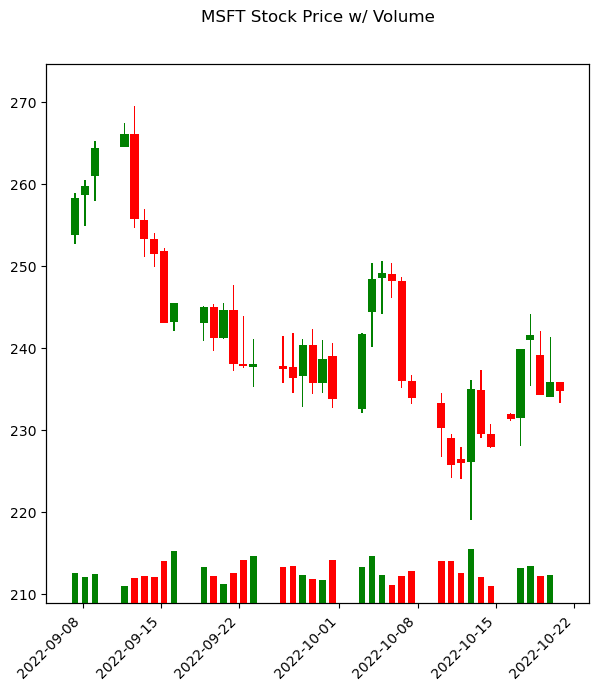

In [87]:
candlesticks(df[-50:], volume=True)

plt.title('MSFT Stock Price w/ Volume\n\n')
plt.savefig('../figures/candlesticks.png')
plt.show()


**Calculating Inefficiencies**

The following function determines if a data point is undervalued, overvalued, efficient, or volatile, given a window period, threshold rate, and confirmation period as follows:

Within the following *window period*, does the stock sustain a price change of at least *threshold rate* for *confirmation period* long?

If it doesn't pass the thresholds it's efficient, if it passes the thresholds with a positive change it's undervalued, if it passes the thresholds with a negative change it's overvalued, and if it exceeds the thresholds in both directions it's volatile. 

In [88]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression




def inefficiencies(df, window_period, threshold_rate, confirmation_window=None, round_up_week=False):
    
    df_ = df.copy()
    # print(len(df))
    imputer = IterativeImputer(estimator = LinearRegression(), random_state=42, max_iter=50)
    # start = df.index
    df_ = pd.DataFrame(data=imputer.fit_transform(df_), columns=df_.columns, index=df_.index)
    # print(df_.head(10))
    # df = df[df.open.notnull()]
    # print(len(df_))
    start = df_.index
    if round_up_week:
        window_period = window_period + pd.Timedelta(weeks=1) - pd.Series([(i.dayofweek+1) * pd.Timedelta(days=1) for i in start])

    end = start + window_period
    ineffy = np.full(len(df_),'efficient')
    horizonmax = [max(df_['high'][(df_.index >= s) & (df.index < e)]) for s, e in zip(start, end)]
    horizonmin = [min(df_['low'][(df_.index >= s) & (df.index < e)]) for s, e in zip(start, end)]
    underpriced = (horizonmax/df_['close'] - 1) > threshold_rate
    overpriced = (horizonmin/df_['close'] - 1) < -threshold_rate
    volatile = underpriced & overpriced

    if confirmation_window:
        end = start + confirmation_window
        underpriced = [underpriced[(df_.index >= s) & (df_.index < e)].all() for s, e in zip(start, end)]
        overpriced = [overpriced[(df_.index >= s) & (df_.index < e)].all() for s, e in zip(start, end)]
        volatile = [u & o for u,o in zip(underpriced, overpriced)]
        
        ineffy[underpriced] = 'underpriced'
        ineffy[overpriced] = 'overpriced'
        ineffy[volatile] = 'volatile'

    else:
    
        ineffy[underpriced] = 'underpriced'
        ineffy[overpriced] = 'overpriced'
        ineffy[volatile] = 'volatile'
        
    return df.join(pd.DataFrame(data=ineffy, index=df.index, columns=['inefficiency'])) 


In [89]:
ineffy = inefficiencies(df,
                     window_period = pd.Timedelta(weeks=1), 
                     threshold_rate =.02, 
                     confirmation_window = pd.Timedelta(days=2))['inefficiency']

#rounds up the horizon period to the following friday
df2 = inefficiencies(df,
                     window_period = pd.Timedelta(weeks=1), 
                     threshold_rate =.02,
                     confirmation_window = pd.Timedelta(days=2),
                     round_up_week=True)

print(df2.head(10))

print()
print('Shorter Horizon Value Counts')
print(ineffy.value_counts())
print()
print('Longer Horizon Value Counts')

print(df2.inefficiency.value_counts())
print(df2.inefficiency.isnull().sum())
print()


                           open        high         low       close    volume  \
time                                                                            
2020-11-02 00:00:00  200.141658  201.743185  196.624196  200.013929  27717738   
2020-11-02 21:16:00  200.505195  204.484447  198.982271  203.826151  24851715   
2020-11-03 18:32:00  203.816326  214.506268  202.401481  213.022646  33883080   
2020-11-04 15:48:00  213.032471  220.087047  212.099066  219.133991  24326621   
2020-11-05 13:04:00  219.143817  220.204951  214.221334  216.343602  18922103   
2020-11-06 10:20:00  216.353427  220.440758  215.695131  219.497528  16597466   
2020-11-07 07:36:00         NaN         NaN         NaN         NaN         0   
2020-11-08 04:52:00         NaN         NaN         NaN         NaN         0   
2020-11-09 02:08:00  223.525907  224.999704  214.064129  214.958233  37370310   
2020-11-09 23:24:00  214.191858  214.191858  206.056498  207.323963  41613279   

                    ineffic

A longer horizon means more datapoints being classified as undervalued, overvalued, and volatile because the longer the horizon the more chances it has to deviate from baseline.

**Visualizing Inefficiencies**

These can be visualized by changing the colors of the candlesticks plot to represent the datapoint's inefficiency class.

In [90]:
def coloredsticks(df):
    
    fig, ax = plt.subplots(figsize=[10,10])

    width = .8/(1400/int(freqq[:-1]))


    width2 = width/6.2

    underpriced = df[df['inefficiency'] == 'underpric']
    overpriced = df[df['inefficiency'] == 'overprice']
    efficient = df[df['inefficiency'] == 'efficient']
    not_null = df[df['inefficiency'] == 'efficient']['open'].notnull()
    efficient = efficient[not_null]
    volatile = df[df['inefficiency'] == 'volatile']

    plt.bar(volatile.index, volatile.close - volatile.open, width, bottom = volatile.open, color='y', label='volatile')
    plt.bar(volatile.index, volatile.high - volatile.close, width2, bottom = volatile.close, color='y')
    plt.bar(volatile.index, volatile.open - volatile.low, width2, bottom = volatile.low, color='y')

    plt.bar(underpriced.index, underpriced.close - underpriced.open, width, bottom = underpriced.open, color='c', label='undervalued')
    plt.bar(underpriced.index, underpriced.high - underpriced.close, width2, bottom = underpriced.close, color='c')
    plt.bar(underpriced.index, underpriced.open - underpriced.low, width2, bottom = underpriced.low, color='c')

    plt.bar(overpriced.index, overpriced.close - overpriced.open, width, bottom = overpriced.open, color='m', label='overvalued')
    plt.bar(overpriced.index, overpriced.high - overpriced.close, width2, bottom = overpriced.close, color='m')
    plt.bar(overpriced.index, overpriced.open - overpriced.low, width2, bottom = overpriced.low, color='m')

    plt.bar(efficient.index, efficient.close - efficient.open, width, bottom = efficient.open, color='b', label='efficient')
    plt.bar(efficient.index, efficient.high - efficient.close, width2, bottom = efficient.close, color='b')
    plt.bar(efficient.index, efficient.open - efficient.low, width2, bottom = efficient.low, color='b')

    plt.legend()
    
    ax.tick_params(axis= 'x', which='major', labelsize=12, rotation=45)
    ax.tick_params(axis= 'y', which='major', labelsize=12)
    plt.ylim(min(df['low'][df.low > 0]) - .2*(max(df['high'][df.high > 0]) - min(df['low'][df.low > 0])),
            max(df['high'][df.high > 0] + .1*(max(df['high'][df.high > 0]) - min(df['low'][df.low > 0]))))
    
    plt.twinx()
    plt.bar(efficient.index, efficient.volume, width*.8, color='b')
    plt.bar(underpriced.index, underpriced.volume, width*.8, color='c')
    plt.bar(overpriced.index, overpriced.volume, width*.8, color='m')
    plt.bar(volatile.index, volatile.volume, width*.8, color='y')
    plt.ylim(0, max(df['volume'])*10)
    plt.tick_params(right= False, labelright=False, size=21)


    return


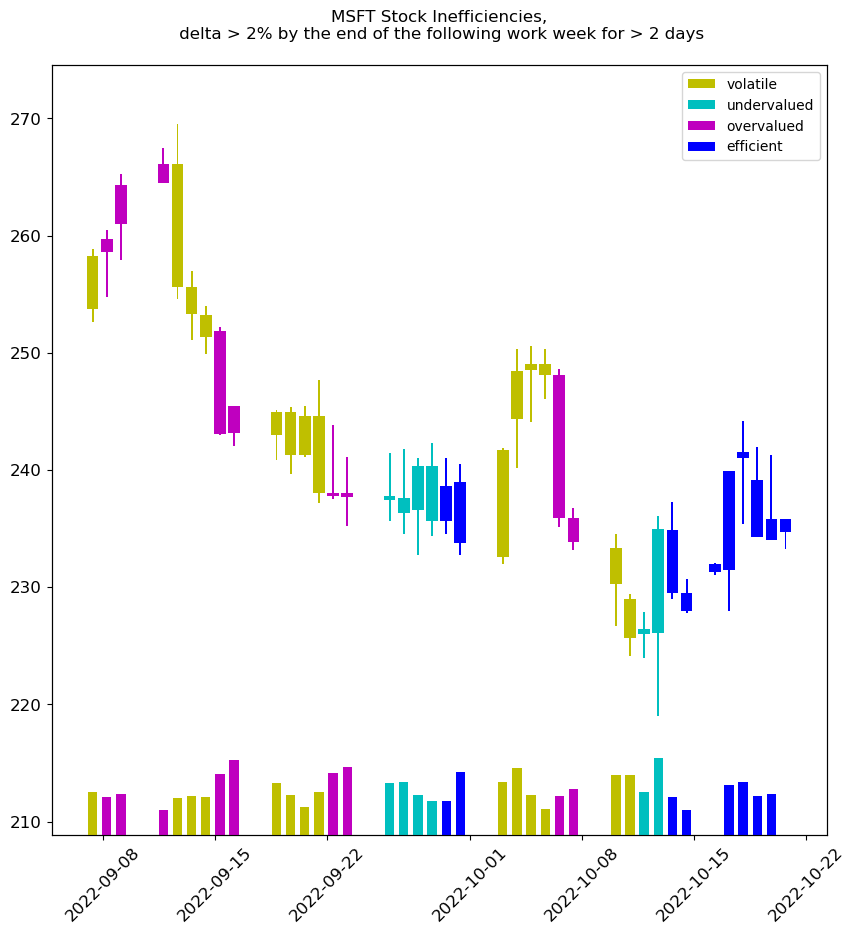

In [91]:
coloredsticks(df2[-50:])
plt.title('MSFT Stock Inefficiencies,\n delta > 2% by the end of the following work week for > 2 days\n')
plt.savefig('../figures/classsticks.png')
plt.show()


The volume frequency distribution of the diffrent classes are visualized below. 

In [92]:
def volume_by_class(df, oneplt=True, violin=False):
    
#     if violin==True:
#         classes = df.inefficiency.unique()
#         dataset = [df[df['inefficiency']==c]['volume'].apply(lambda x:np.log10(x+1))
#                   for c in classes]

#         plt.violinplot(dataset=dataset, points=100)
#         # plt.semilogy()
#         plt.xticks([1,2,3,4],['underpriced','volatile', 'efficient', 'overpriced'])
#         plt.yticks([0,1,2,3,4,5,6,7,8],['$10^0$','$10^1$','$10^2$','$10^3$','$10^4$','$10^5$','$10^6$','$10^7$','$10^8$'])


#         plt.ylabel('Volume [# of shares traded]')
#         plt.xlabel('Effiency Class')
#         # plt.ylim(4,8)
#         plt.show()
#     if oneplt==True:
#         colors = ['b', 'm', 'c', 'y']
#         classes = ['efficient', 'underpric', 'overprice', 'volatile']
#         labels = ['efficient', 'underpriced', 'overpriced', 'volatile']
#         for i,c in enumerate(classes):
#             plt.hist(df[df.inefficiency==c].volume, bins=np.logspace(2, 8, 20), alpha = .9, label=labels[i], color=colors[i])
#         plt.xlabel('Volume [# of traded shares]')
#         plt.ylabel('Frequency')
#         plt.title('Volume Frequency by Inefficiency Class')
#         plt.tight_layout()
#         plt.semilogx()
#         plt.legend()
#         plt.show()
#     else:
    fig=plt.figure(figsize=[8,5])
    gs=fig.add_gridspec(4,hspace=0)
    axs = gs.subplots(sharex=True, sharey=True)
    colors = ['b', 'm', 'c', 'y']
    classes = ['efficient', 'underpric', 'overprice', 'volatile']
    labels = ['efficient', 'underpriced', 'overpriced', 'volatile']
    for i,c in enumerate(classes):
        class_volume = df[df.inefficiency==c].volume
        class_volume = class_volume[class_volume.notnull()]
        axs[i].hist(class_volume, bins=np.logspace(2, 8, 90),alpha = .9, label=labels[i], color=colors[i])
        axs[i].axvline(class_volume.median(), linestyle=':', color=(0,0,0), alpha=.5)
        axs[i].axvline(class_volume.mean(), linestyle=':', color=(1,1,0), alpha=1)
        # axs[i].axvline(df[df.notnull()].volume.median(), linestyle=':', color=(1,0,0), alpha=.5)
        # axs[i].axhline(len(class_volume)/90, linestyle=':', color=(1,0,0), alpha=.5)

    plt.xlabel('Volume [# of traded shares]')
    fig.text(0,.5,'Frequency\n',rotation='vertical', va='center')
    fig.text(.5,0, 'The median and mean are shown in black and yellow, respectively. The volatile class has the largest average\n mean and median volume, and the efficient class  has the smallest mean and median values.', ha='center')

    fig.suptitle('Volume Frequency by Inefficiency Class')
    fig.tight_layout(pad=3)
    plt.semilogx()
    fig.text(.25,.73,'efficient', va='center', color='b')

    fig.text(.25,.57,'overvalued', va='center', color='m')

    fig.text(.25,.41,'undervalued', va='center', color='c')

    fig.text(.25,.25,'volatile', va='center', color='y')




    return


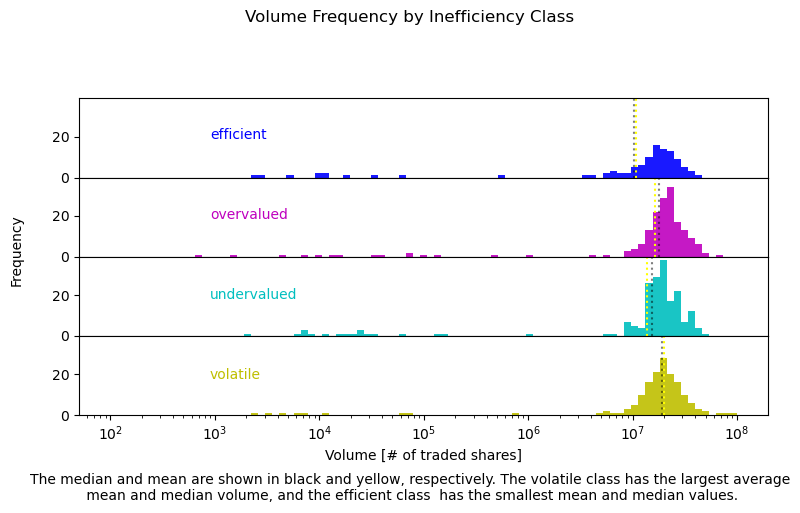

In [93]:
volume_by_class(df2, oneplt=False)
# plt.tight_layout()
plt.savefig('../figures/volume_hist_by_class.png')
plt.show()


**Splitting the Data**

2021 will serve as the training set, 2022 Q1 will be the validation set and and 2022 Q2 will be the test set. 

In [94]:
def split_time_series(df, train_rate, val_rate, test_rate):
    
    rates = [train_rate, val_rate, test_rate]
    
    for rate in rates:
        try:
            assert(type(rate) == type(1.1))
        except AssertionError:
            print('rate must be float')
    try:
        assert(sum(rates) == 1)
    except AssertionError:
        print('rates must sum to 1')
            
    train_i = int(len(df.index)*train_rate)
    test_i = train_i + int((len(df.index) - train_i)*(val_rate/(val_rate+test_rate)))
    
    train_X = df[df.columns[:-1]].iloc[:train_i]
    test_X = df[df.columns[:-1]].iloc[train_i:test_i]
    val_X = df[df.columns[:-1]].iloc[test_i:]
    
    train_y = df[df.columns[-1]].iloc[:train_i]
    test_y = df[df.columns[-1]].iloc[train_i:test_i]
    val_y = df[df.columns[-1]].iloc[test_i:]
    
    return train_X, train_y, test_X, test_y, val_X, val_y

In [95]:
# jan1 2020 - june30 2021
df3 = df2[(df2.index > '2021-1-1')&(df2.index< '2022-7-1')]


X_train, y_train, X_test, y_test, X_val, y_val = split_time_series(df3,.67, .165, .165)

sets = [X_train, y_train, X_test, y_test, X_val, y_val]

print('X train index range')
print('start', X_train.index[0])
print('stop', X_train.index[-1], '\n')


print('X test index range')
print('start', X_test.index[0])
print('stop', X_test.index[-1], '\n')


print('X val index range')
print('start', X_val.index[0])
print('stop', X_val.index[-1], '\n')


X train index range
start 2021-01-01 06:08:00
stop 2021-12-31 10:44:00 

X test index range
start 2022-01-01 08:00:00
stop 2022-03-31 19:56:00 

X val index range
start 2022-04-01 17:12:00
stop 2022-06-30 05:08:00 



**Preprocessing**

Autoregression is used to create lag features. 

In [96]:
def autoregression(df, lag):
    lag_features = [df.shift(i) for i in range(lag + 1)]
    X = pd.concat(lag_features,axis=1)
    X.columns = [*df.columns, *[c+' lag'+str(int(i/len(df.columns))) for i,c in  enumerate(X.columns) if i >= len(df.columns)]]
    return X.copy()

def autoregression2(df, lag):
    lag_features = [df.shift(i) for i in range(lag + 1)]
    X = pd.concat(lag_features,axis=1)
    X.columns = [*df.columns, *[c+' lag'+str(int(i/len(df.columns))) for i,c in  enumerate(X.columns) if i >= len(df.columns)]]
    return X.copy()

X_train = autoregression(X_train,1)
X_test = autoregression(X_test,1)
X_val = autoregression(X_val,1)


print(X_train.columns)
print(len(set(X_train.columns)))
print(len(X_train.columns))

Index(['open', 'high', 'low', 'close', 'volume', 'open lag1', 'high lag1',
       'low lag1', 'close lag1', 'volume lag1'],
      dtype='object')
10
10


Differencing is used to increase stationarity.

In [97]:
def differencing(df, lag):
    lag_features = [df - df.shift(i) for i in np.arange(1,lag+1)]
    X = pd.concat([df, *lag_features],axis=1)
    X.columns = [*df.columns, *[c+' difference'+str(int(i/len(df.columns))) for i,c in  enumerate(X.columns) if i>=len(df.columns)]]
    return X.copy()

def differencing2(df, lag):
    lag_features = [df - df.shift(i) for i in np.arange(1,lag+1)]
    X = pd.concat(lag_features, axis=1)
    X.columns = [c+' diff'+str(int(i/len(df.columns))) for i,c in  enumerate(X.columns)]
    return X.copy()

X_train = differencing2(X_train,1)
X_test = differencing2(X_test,1)
X_val = differencing2(X_val,1)

print(X_train.columns)
print(len(set(X_train.columns)))
print(len(X_train.columns))

Index(['open diff0', 'high diff0', 'low diff0', 'close diff0', 'volume diff0',
       'open lag1 diff0', 'high lag1 diff0', 'low lag1 diff0',
       'close lag1 diff0', 'volume lag1 diff0'],
      dtype='object')
10
10


The features are standardized.

In [98]:
std_ftrs = X_train.columns
# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) 


X_train_prep = clf.fit_transform(X_train)
X_test_prep = clf.transform(X_test)
X_val_prep = clf.transform(X_val)


fix = lambda x: np.nan_to_num(x,nan=-5)

fix(X_train_prep)

array([[-5.00000000e+00, -5.00000000e+00, -5.00000000e+00, ...,
        -5.00000000e+00, -5.00000000e+00, -5.00000000e+00],
       [-5.00000000e+00, -5.00000000e+00, -5.00000000e+00, ...,
        -5.00000000e+00, -5.00000000e+00, -5.00000000e+00],
       [-5.00000000e+00, -5.00000000e+00, -5.00000000e+00, ...,
        -5.00000000e+00, -5.00000000e+00, -2.00501793e-03],
       ...,
       [-3.18352536e-01, -6.24439721e-01,  1.07351965e-01, ...,
        -3.28781922e-01, -3.60122886e-01, -3.19753759e-02],
       [-4.50611698e-01, -7.21172329e-01, -1.42108403e+00, ...,
         1.06306021e-01, -4.63457077e-01, -3.72511785e-01],
       [-1.25591970e+00, -1.28083956e+00, -2.26811798e-01, ...,
        -1.41940237e+00, -1.29316984e+00,  8.16591766e-02]])

**Testing the Classifier**

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def simple_ML_pipeline(X_train,X_test,y_train,y_test):
    LR = LogisticRegression(penalty='l2', C = 1, max_iter = 10000, random_state=42) # logistic regression is a simple linear classifier
    LR.fit(X_train,y_train)
    y_test_pred = LR.predict(X_test)
    return accuracy_score(y_test, y_test_pred)
    

print(y_train[y_train.notnull()])
test_score = simple_ML_pipeline(fix(X_train_prep)[y_train.notnull()],fix(X_test_prep)[y_test.notnull()],y_train[y_train.notnull()],y_test[y_test.notnull()])
print('baseline', y_train.value_counts()[0]/len(y_train))
print(test_score)

time
2021-01-01 06:08:00    overprice
2021-01-02 03:24:00    overprice
2021-01-03 00:40:00    overprice
2021-01-03 21:56:00    underpric
2021-01-04 19:12:00    underpric
                         ...    
2021-12-27 21:40:00    overprice
2021-12-28 18:56:00    overprice
2021-12-29 16:12:00    overprice
2021-12-30 13:28:00    efficient
2021-12-31 10:44:00    efficient
Freq: 1276T, Name: inefficiency, Length: 412, dtype: object
baseline 0.32038834951456313
0.3333333333333333


In [100]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from random import shuffle
df = pd.read_csv('../data/alpha/MSFT.csv', 
                 parse_dates=['time'], 
                 index_col='time')

def pipeline(df, freq, Model, params, auto_lag=0, diff_lag=0, feature_order=0):
    
    df = df.resample(freq).agg(column_funcs)
    df = inefficiencies(df,
                     window_period = pd.Timedelta(weeks=1), 
                     threshold_rate =.02,
                     confirmation_window = pd.Timedelta(days=2),
                     round_up_week=True)
    
    X_test = df[(df.index > '2022-4-1')&(df.index< '2022-7-1')].iloc[:,:-1]
    y_test = df[(df.index > '2022-4-1')&(df.index< '2022-7-1')].iloc[:,-1]
            
    df_other = df[(df.index > '2021-1-1')&(df.index< '2022-4-1')]
    X_other = df_other.iloc[:,:-1]
    y_other = df_other.iloc[:,-1]
    
    tscv = TimeSeriesSplit()
    
    val_scores = []
    
    for train_index, val_index in tscv.split(df_other):
        X_train, y_train = X_other.iloc[train_index], y_other.iloc[train_index]
        X_val, y_val = X_other.iloc[val_index], y_other.iloc[val_index]
        
    # X_train, y_train, X_test, y_test, X_val, y_val = split_time_series(df,.67, .165, .165)
        
        if auto_lag > 1:
            X_train = autoregression(X_train, auto_lag)
            X_val = autoregression(X_val, auto_lag)

        if diff_lag > 0:
            X_train = differencing(X_train, diff_lag)
            X_val = differencing(X_val, diff_lag)
            # print(X_train.shape)
        
        if (auto_lag > 1) or (diff_lag > 0):
            X_train = X_train[max(auto_lag, diff_lag) + 1:]
            X_val = X_val[max(auto_lag, diff_lag) + 1:]
            y_train = y_train[max(auto_lag, diff_lag) + 1:]
            y_val = y_val[max(auto_lag, diff_lag) + 1:]
        
        std_ftrs = X_train.columns
        preprocessor = ColumnTransformer(
            transformers=[
                ('std', StandardScaler(), std_ftrs)])
        # print('giddy up')
        
        clf = Pipeline(steps=[('preprocessor', preprocessor)]) 

        X_train_prep = clf.fit_transform(X_train)
        X_val_prep = clf.transform(X_val)
        
        X_train_prep = X_train_prep[y_train.notnull()]
        X_val_prep = X_val_prep[y_val.notnull()]
        y_train = y_train[y_train.notnull()]
        y_val = y_val[y_val.notnull()]
        
        
        idx_X_train = list(range(len(X_train_prep)))
        shuffle(idx_X_train)
        
        X_train_prep = X_train_prep[idx_X_train]
        y_train = y_train[idx_X_train]
        
        # print(X_train_prep.shape)        
        if feature_order > 1:
            # print(X_train_prep)
            # print(X_train_prep.shape)
            
            poly = PolynomialFeatures(feature_order)
            X_train_prep = poly.fit_transform(fix(X_train_prep))
            X_val_prep = poly.fit_transform(fix(X_val_prep))
            # print(X_train_prep.shape)
        
        model = Model(**params) 
        model.fit(X_train_prep,y_train)
        y_val_pred = model.predict(X_val_prep)
        val_score = accuracy_score(y_val, y_val_pred)

        # test_score = simple_ML_pipeline(fix(X_train_prep)[y_train.notnull()],fix(X_test_prep)[y_test.notnull()],y_train[y_train.notnull()],y_test[y_test.notnull()])
        print('baseline', y_train.value_counts()[0]/len(y_train))
        print('val',val_score)
        baseline = y_train.value_counts()[0]/len(y_train)
        val_scores.append((val_score, baseline))

    return val_scores


In [27]:
params = {
    'penalty' :'l2',
    'C' : 1/10000,
    'max_iter' : 1000000,
    'random_state' : 42
}

pipeline(df=df,
         freq='1276T',
         Model=LogisticRegression,
         params=params,
        auto_lag=3,
        diff_lag=4,
        feature_order=3)

KeyboardInterrupt: 

In [65]:
params = {
    'penalty' :'l2',
    'C' : 1/10000,
    'max_iter' : 1000000,
    'random_state' : 42
}

pipeline(df=df,
         freq='1276T',
         Model=LogisticRegression,
         params=params,
        auto_lag=2,
        diff_lag=2,
        feature_order=4)

baseline 0.4090909090909091
val 0.3968253968253968
baseline 0.4166666666666667
val 0.12698412698412698
baseline 0.43434343434343436
val 0.2857142857142857
baseline 0.45075757575757575
val 0.2222222222222222
baseline 0.41515151515151516
val 0.30158730158730157


[(0.3968253968253968, 0.4090909090909091),
 (0.12698412698412698, 0.4166666666666667),
 (0.2857142857142857, 0.43434343434343436),
 (0.2222222222222222, 0.45075757575757575),
 (0.30158730158730157, 0.41515151515151516)]

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# custom encoders 

class Autoregression(BaseEstimator, TransformerMixin):
    
    def __init__(self, lag=1):
        self.lag = lag
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Perform arbitary transformation
        print(X.shape)
        X_ = X.copy()
        lag_features = [X_.shift(i) for i in range(1, self.lag+1)]
        X_ = pd.concat([X_, *lag_features],axis=1)
        X_.columns = [*X.columns, *[c+' lag'+str(int(i/len(X.columns))) for i,c in  enumerate(X_.columns) if i >= len(X.columns)]]
        print(X_.shape)
        print(X_.columns)
        return X_
    
    
class Differencing(BaseEstimator, TransformerMixin):
    
    def __init__(self, lag=1):
        self.lag = lag
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Perform arbitary transformation
        print(X.shape)
        X_ = X.copy()
        lag_features = [X_ - X_.shift(i) for i in np.arange(1,self.lag+1)]
        X_ = pd.concat([X_, *lag_features],axis=1)
        X_.columns = [*X.columns, *[c+' diff'+str(int(i/len(X.columns))) for i,c in  enumerate(X_.columns) if i >= len(X.columns)]]
        print(X_.shape)
        return X_
    
    
    
class Autodifference(BaseEstimator, TransformerMixin):
    
    def __init__(self, auto_lag=1, diff_lag=1):
        self.auto_lag = auto_lag
        self.diff_lag = diff_lag
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Perform arbitary transformation
        X_ = X.copy()
        auto_features = [X_.shift(i) for i in range(0, self.auto_lag + 1)]
        X_ = pd.concat(auto_features, axis =1)
        X_.columns = [*X.columns, *[c+' lag'+str(int(i/len(X.columns))) for i,c in  enumerate(X_.columns) if i >= len(X.columns)]]
        
        X_2 = X_.copy()
        diff_features = [X_2 - X_2.shift(i) for i in np.arange(1,self.diff_lag+1)]
        X_2 = pd.concat([X_2, *diff_features],axis=1)
        X_2.columns = [*X_.columns,*[c+' diff'+str(int(i/len(X_.columns))) for i,c in  enumerate(X_2.columns) if i >= len(X_.columns)]]
        
        # trimmin window bounds
        crop = max(auto_lag, diff_lag) + 1
        
        return X_2
    
class Autodifference2(BaseEstimator, TransformerMixin):
    
    def __init__(self, auto_lag=1, diff_lag=1):
        self.auto_lag = auto_lag
        self.diff_lag = diff_lag
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        auto_features = [X_.shift(i) for i in range(self.auto_lag + 1)]
        X_ = pd.concat(auto_features,axis=1)
        X_.columns = [*X.columns, *[c+' lag'+str(int(i/len(X.columns))) for i,c in  enumerate(X_.columns) if i >= len(X.columns)]]
        
        X_2 = X_.copy()
        diff_features = [X_2 - X_2.shift(i) for i in np.arange(1,self.diff_lag+1)]
        X_2 = pd.concat(diff_features,axis=1)
        X_2.columns = [c+' diff'+str(int(i/len(X_.columns))) for i,c in  enumerate(X_2.columns)]

        return fix(X_2)
    
agg_funcs = {'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'}
    
# class Resample(BaseEstimator, TransformerMixin):
    
#     def __init__(self, freq='1276T', agg_funcs=agg_funcs):
#         self.freq = freq
#         self.agg_funcs = agg_funcs
        
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         # Perform arbitary transformation
#         X_ = X.copy()
#         return X_.resample(freq).agg(agg_funcs)

    
# class Inefficiencies(BaseEstimator, TransformerMixin):
    
#     def __init__(self, window_period=pd.Timedelta(weeks=1), threshold_rate=.02, confirmation_window=pd.Timedelta(days=2), round_up_week=True):
#         self.window_period = window_period
#         self.threshold_rate = threshold_rate
#         self.confirmation_window = confirmation window
#         self.round_up_week= round_up_week
        
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         # Perform arbitary transformation        
#         X_ = X.copy()
#         X_ = X_[X_.open.notnull()]
#         start = X_.index
#         if round_up_week:
#             self.window_period = self.window_period + pd.Timedelta(weeks=1) - pd.Series([(i.dayofweek+1) * pd.Timedelta(days=1) for i in start])

#         end = start + self.window_period
#         inefficiencies = np.full(len(X_),'efficient')
#         horizonmax = [max(X_['high'][(start >= s) & (start < e)]) for s, e in zip(start, end)]
#         horizonmin = [min(X_['low'][(start >= s) & (start < e)]) for s, e in zip(start, end)]
#         underpriced = (horizonmax/X_['close'] - 1) > self.threshold_rate
#         overpriced = (horizonmin/X_['close'] - 1) < -self.threshold_rate
#         volatile = underpriced & overpriced

#         if confirmation_window:
#             end = start + self.confirmation_window
#             underpriced = [underpriced[(start >= s) & (start < e)].all() for s, e in zip(start, end)]
#             overpriced = [overpriced[(start >= s) & (start < e)].all() for s, e in zip(start, end)]
#             volatile = [u & o for u,o in zip(underpriced, overpriced)]

#             inefficiencies[underpriced] = 'underpriced'
#             inefficiencies[overpriced] = 'overpriced'
#             inefficiencies[volatile] = 'volatile'

#         else:

#             inefficiencies[underpriced] = 'underpriced'
#             inefficiencies[overpriced] = 'overpriced'
#             inefficiencies[volatile] = 'volatile'

#         return X_.join(pd.DataFrame(data=inefficiencies, index=start, columns=['inefficiency']))
    


print('giddy up')
    
freq = '1276T'

df = pd.read_csv('../data/alpha/MSFT.csv', 
                 parse_dates=['time'], 
                 index_col='time')

df = df[(df.index > '2021-1-1')&(df.index< '2022-7-1')]

df = df.resample(freq).agg(agg_funcs)

# let's separate the feature matrix X, and target variable y
df = inefficiencies(df,
     window_period = pd.Timedelta(weeks=1), 
     threshold_rate =.02,
     confirmation_window = pd.Timedelta(days=2),
     round_up_week=True)

df = df[(df.open > 0) & (df.inefficiency > 'a')] 

print(df.isnull().sum())
X = df.iloc[:,:-1] 
y = df['inefficiency']

# collect which encoder to use on each feature
# needs to be done manually
auto_lag = 1

std_ftrs = X.columns
auto_ftrs = X.columns
diff_ftrs = [*X.columns, *[c+' lag'+str(i) for c in X.columns for i in range(1, auto_lag+1)]]
print(diff_ftrs)
freq_ftrs = X.columns
ineffy_ftrs = X.columns 

# collect all the encoders into one preprocessor

preprocessor = ColumnTransformer(
    transformers=[
        # ('ineffy', Inefficiency())
        # ('freq', Resample(), freq_ftrs),
        # ('diff', Differencing(), diff_),
        # ('auto', Autoregression(), auto_ftrs),
        ('autodiff', Autodifference2(), auto_ftrs),
        ('std', StandardScaler(), std_ftrs)])

print('giddy up')



# we will loop through nr_states random states so we will return nr_states test scores and nr_states trained models
nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []

param_grid = {
    'randomforestclassifier__max_depth': [1, 3, 10, 30, 100], # no upper bound so the values are evenly spaced in log
    'randomforestclassifier__max_features': [0.25, 0.5,0.75,1.0] # linearly spaced because it is between 0 and 1, 0 is omitted
} 


print('giddy up')
# loop through the different random states
for i in range(nr_states):
    print('\n\nrandoms state '+str(i+1))

    # first split to separate out the test set
    X_test = df[(df.index > '2022-4-1')&(df.index< '2022-7-1')].iloc[:,:-1]
    y_test = df[(df.index > '2022-4-1')&(df.index< '2022-7-1')].iloc[:,-1]
    print('baseline', y_train.value_counts().values[0]/len(y_train))
    df_other = df[(df.index > '2021-1-1')&(df.index< '2022-4-1')]
    X_other = df_other.iloc[:,:-1]
    y_other = df_other.iloc[:,-1]

    # second split to separate out the validation and train sets
    tscv = TimeSeriesSplit()

#     for train_index, val_index in tscv.split(df_other):
#         X_train, y_train = X_other.iloc[train_index], y_other.iloc[train_index]
#         X_val, y_val = X_other.iloc[val_index], y_other.iloc[val_index]
        
    # the classifier
    clf = RandomForestClassifier(random_state = 42*i) # initialize the classifier

    # let's put together a pipeline
    # the pipeline will fit_transform the training set (3 folds), and transform the last fold used as validation
    # then it will train the ML algorithm on the training set and evaluate it on the validation set
    # it repeats this step automatically such that each fold will be an evaluation set once
    pipe = make_pipeline(preprocessor,clf)

    # use GridSearchCV
    # GridSearchCV loops through all parameter combinations and collects the results 
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                        cv=tscv, return_train_score = True, n_jobs=-1, verbose=True)
    
    # this line actually fits the model on other
    print(y_other.shape, y_other.value_counts())
    print(X_other.shape, X_other.value_counts())
    print(param_grid)
    

    grid.fit(X_other, y_other)
    # save results into a data frame. feel free to print it and inspect it
    results = pd.DataFrame(grid.cv_results_)
    #print(results)

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
    # save the model
    final_models.append(grid)
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test)
    test_scores[i] = accuracy_score(y_test,y_test_pred)
    print('test score:',test_scores[i])


giddy up
open            0
high            0
low             0
close           0
volume          0
inefficiency    0
dtype: int64
['open', 'high', 'low', 'close', 'volume', 'open lag1', 'high lag1', 'low lag1', 'close lag1', 'volume lag1']
giddy up
giddy up


randoms state 1
baseline 0.4043887147335423
(399,) underpric    154
overprice    112
efficient     76
volatile      57
Name: inefficiency, dtype: int64
(399, 5) open        high        low         close       volume  
209.851762  215.528522  208.790177  215.045804  17888902    1
298.624208  302.974313  296.956834  302.436771  19368097    1
298.385301  299.062205  297.419717  297.449581  42066       1
298.286467  301.885895  297.988101  301.737158  15095936    1
298.235984  302.367090  294.363694  296.663177  14210036    1
                                                           ..
254.886728  257.394717  254.007945  257.266356  20728742    1
254.850339  255.256104  254.612817  254.988893  3880751     1
254.462246  256.920767  25

Traceback (most recent call last):
  File "/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/runpy.py", line 187, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/runpy.py", line 187, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/runpy.py", line 187, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/runpy.py", line 187, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/runpy.py", line 187, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/runpy.py", line 187, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/runpy.py", line 187, in _run_module_

KeyboardInterrupt: 

**Cross Validation**

Below a hyperparmeter grid is tested. First the pipeline is made:

Importing additional libraries that are needed and defining some constants:

In [102]:
import pickle
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline


nr_states = 5
freq = '1276T'
date_begin = '2021-1-1'
date_end = '2022-7-1'
autoregression_lag = 2
difference_lag = 4
ineff_params = {
    'window_period': pd.Timedelta(weeks=1),
    'threshold_rate': 0.02,
    'confirmation_window': pd.Timedelta(days=2),
    'round_up_week': True}
agg_funcs = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'}
param_gridsA = [
    {'randomforestclassifier__n_estimators': [100, 200, 300],
     'randomforestclassifier__max_depth': [3, 5, 7, 9],
     'randomforestclassifier__max_features': [0.1,0.3,0.5,0.7]},

    {'svc__C': np.logspace(-1,3,5),
     'svc__gamma': np.logspace(-1,2,4)}, 
    
    {'kneighborsclassifier__n_neighbors': [1,3,10,30,100],
     'kneighborsclassifier__p': [1,2], 
     'kneighborsclassifier__weights': ['uniform', 'distance']},
    
    {'logisticregression__penalty' : ['elasticnet'],
    'logisticregression__solver' : ['saga'],
    'logisticregression__l1_ratio' : np.linspace(.1,.9, 5),
    'logisticregression__C' : np.logspace(-3,3,7),
    'logisticregression__max_iter' : [1000000]}
]
test_models = [RandomForestClassifier, SVC, KNeighborsClassifier, LogisticRegression]

Defining some helper functions

In [103]:
date_range = lambda df: (df.index > date_begin)&(df.index < date_end)

fix = lambda x: np.nan_to_num(x,nan=-5)

# ! add split fn for test/other separation

class Ranges(BaseEstimator,TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_['range'] = X['open'] - X['close']
        X_['delta'] = X['high'] - X['low']
        # print(X_.shape)
        return X_
    
class Autodifference2(BaseEstimator, TransformerMixin):
    
    def __init__(self, auto_lag=1, diff_lag=1):
        self.auto_lag = auto_lag
        self.diff_lag = diff_lag
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # print(X.shape)
        X_ = X.copy()
        auto_features = [X_.shift(i) for i in range(self.auto_lag + 1)]
        X_ = pd.concat(auto_features,axis=1)
        X_.columns = [*X.columns, *[c+' lag'+str(int(i/len(X.columns))) for i,c in  enumerate(X_.columns) if i >= len(X.columns)]]
        # print(X_.shape)
        # print(X_.columns)        
        X_2 = X_.copy()
        diff_features = [X_2 - X_2.shift(i) for i in np.arange(1,self.diff_lag+1)]
        X_2 = pd.concat(diff_features,axis=1)
        X_2.columns = [c+' diff'+str(int(i/len(X_.columns))) for i,c in  enumerate(X_2.columns)]
        # print(X_2.shape)
        # print(X_2.columns)
        return X_2#[max(self.auto_lag, self.diff_lag) + 1:]
    
# # read in the appropriate range and frequency 
# df = pd.read_csv('../data/alpha/MSFT.csv', 
#                  parse_dates=['time'], 
#                  index_col='time')

# df = df[date_range(df)]
# df = df.resample(freq).agg(agg_funcs)

# # generating the target variable
# df = inefficiencies(df, **ineff_params)
# # df = df[(df.open > 0) & (df.inefficiency > 'a')] 
# # print(df.isnull().sum())

# # separating the feature matrix X and target variable y
# X = df.iloc[:,:-1] 
# y = df.iloc[:,-1]
# print(X.shape)
# print(X.head(7))
# auto = Autodifference2(auto_lag=2, diff_lag=4)
# temp = auto.fit_transform(X,y)
# print(temp.shape)
# print(temp[:7])

# mask = np.isnan(temp)
# unique_rows, counts = np.unique(mask, axis=0,return_counts=True)
# print(len(unique_rows)) # 6 patterns, we will train 6 models
# for i in range(len(counts)):
#     print(unique_rows[i],counts[i])

In [104]:
# defining the preprocessor
preprocessor = [
    Ranges(),
    Autodifference2(auto_lag=2, diff_lag=2), 
    IterativeImputer(estimator = LinearRegression(), random_state=42, max_iter=500), 
    StandardScaler()
]

# all_columns = lambda X: X.columns
# autodiff_ftrs=['open', 'high', 'low', 'close', 'volume', 'delta', 'range']
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('ranges', Ranges(), all_columns),
#         ('autodiff', Autodifference2(auto_lag=autoregression_lag, diff_lag=difference_lag), autodiff_ftrs),
#         ('impute', IterativeImputer(estimator = LinearRegression(), random_state=42), all_columns),
#         ('std', StandardScaler(), all_columns)
#     ],remainder='passthrough')

# defining the pipeline
def MLpipe_KFold_Accuracy(X, y, preprocessor, model, param_grid):
    
    nr_states = 5
    test_scores = np.zeros(nr_states)
    final_models = []
    best_params = []
    scores = []

    for i in range(nr_states):
        
        X_test = X[(df.index > '2022-4-1')&(df.index< '2022-7-1')]
        y_test = y[(df.index > '2022-4-1')&(df.index< '2022-7-1')]
        
        X_other = X[(df.index > '2021-1-1')&(df.index< '2022-4-1')]
        y_other = y[(df.index > '2021-1-1')&(df.index< '2022-4-1')]
  
        tscv = TimeSeriesSplit(n_splits = 3)
        
        if model == KNeighborsClassifier:
            pipe = make_pipeline(*preprocessor, model())

        else:
            pipe = make_pipeline(*preprocessor, model(random_state=i*42))

        
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                            cv=tscv, return_train_score = True, n_jobs=-1, verbose=True)

        grid.fit(X_other, y_other)
        
        # save the output so I can use it later
        file = open('../results/multivariate/grid'+model.__name__+str(i)+'.save', 'wb')
        pickle.dump(grid,file)
        file.close()
        
        final_models.append(grid.best_estimator_)
        best_params.append(grid.best_params_)
        scores.append(grid.best_score_)
        
        print(model.__name__, i, grid.best_params_, grid.best_score_)
        print(grid.best_estimator_.score(X_test,y_test))
        print(grid.cv_results_['mean_train_score'])


    return final_models, scores


# print(y)
# print('baseline: ')


# ranges = Ranges()
# print(X.head(20))
# X_ = ranges.transform(X).head(20)
# print(X_.shape)
# autodiff = Autodifference2(auto_lag=2, diff_lag=4)
# X__ = autodiff.transform(X_)
# print(X__)
# print(X__.columns)
# imputer = IterativeImputer(estimator = LinearRegression(), random_state=42, max_iter=500)
# X___ = imputer.fit_transform(X__)
# X___ = pd.DataFrame(data=X___, columns = X__.columns)
# print(X___)
# print(X.shape)
# pipe= make_pipeline(*preprocessor)
# transformed = pipe.fit_transform(X)
# print(sum(np.isnan(transformed)))
# print(len(X))



Reading in and preparing the dataset, then running the data through the multivariate imputation pipeline, and saving the results:

In [355]:
# read in the appropriate range and frequency 
df = pd.read_csv('../data/alpha/MSFT.csv', 
                 parse_dates=['time'], 
                 index_col='time')

df = df[date_range(df)]
df = df.resample(freq).agg(agg_funcs)
# print(df)

# generating the target variable
df = inefficiencies(df, **ineff_params)
# df = df[(df.open > 0) & (df.inefficiency > 'a')] 
# print(df.isnull().sum())

# separating the feature matrix X and target variable y
X = df.iloc[:,:-1].astype({'volume':'float'}) 
y = df.iloc[:,-1]

print('giddy up')
model_params = zip(test_models, param_gridsA)
model_scores = [MLpipe_KFold_Accuracy(X, y, preprocessor, model, param_grid) 
                for (model, param_grid) in model_params]


giddy up
Fitting 3 folds for each of 48 candidates, totalling 144 fits
RandomForestClassifier 0 {'randomforestclassifier__max_depth': 9, 'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 100} 0.27821522309711283
0.22549019607843138
[0.67855058 0.67855058 0.67378134 0.68116488 0.68931608 0.68587379
 0.69671942 0.70191762 0.70492082 0.69886469 0.70532998 0.70792401
 0.81419241 0.82630512 0.82804123 0.84576084 0.84190986 0.84580091
 0.85662627 0.86267273 0.86006856 0.86731164 0.86396974 0.8596396
 0.92345387 0.92695602 0.92352386 0.93858958 0.94548382 0.94162271
 0.94421674 0.95155008 0.95111099 0.95194911 0.95498224 0.950213
 0.95927232 0.96187649 0.95888342 0.97269172 0.97399887 0.97616394
 0.98049408 0.97919707 0.98265915 0.98526332 0.98439527 0.98569228]
Fitting 3 folds for each of 48 candidates, totalling 144 fits
RandomForestClassifier 1 {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.7, 'randomforestclassifier__n

/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and

KNeighborsClassifier 0 {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'} 0.29658792650918636
0.30392156862745096
[1.         1.         1.         1.         0.69842674 1.
 0.69071464 1.         0.58403755 1.         0.58830736 1.
 0.53009032 1.         0.51675059 1.         0.39325302 1.
 0.39152704 1.        ]
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and

KNeighborsClassifier 1 {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'} 0.29658792650918636
0.30392156862745096
[1.         1.         1.         1.         0.69842674 1.
 0.69071464 1.         0.58403755 1.         0.58830736 1.
 0.53009032 1.         0.51675059 1.         0.39325302 1.
 0.39152704 1.        ]
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and

KNeighborsClassifier 2 {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'} 0.29658792650918636
0.30392156862745096
[1.         1.         1.         1.         0.69842674 1.
 0.69071464 1.         0.58403755 1.         0.58830736 1.
 0.53009032 1.         0.51675059 1.         0.39325302 1.
 0.39152704 1.        ]
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and

KNeighborsClassifier 3 {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'} 0.29658792650918636
0.30392156862745096
[1.         1.         1.         1.         0.69842674 1.
 0.69071464 1.         0.58403755 1.         0.58830736 1.
 0.53009032 1.         0.51675059 1.         0.39325302 1.
 0.39152704 1.        ]
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zacharymor/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and

KNeighborsClassifier 4 {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'} 0.29658792650918636
0.30392156862745096
[1.         1.         1.         1.         0.69842674 1.
 0.69071464 1.         0.58403755 1.         0.58830736 1.
 0.53009032 1.         0.51675059 1.         0.39325302 1.
 0.39152704 1.        ]
Fitting 3 folds for each of 35 candidates, totalling 105 fits
LogisticRegression 0 {'logisticregression__C': 0.001, 'logisticregression__l1_ratio': 0.1, 'logisticregression__max_iter': 1000000, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'} 0.3070866141732283
0.13725490196078433
[0.36684319 0.36684319 0.36684319 0.36684319 0.36684319 0.46174626
 0.3685793  0.36684319 0.36684319 0.36684319 0.5670552  0.54767961
 0.53896912 0.51917423 0.52088041 0.60097775 0.59964067 0.59538052
 0.59281642 0.58978329 0.62282765 0.62153064 0.62153064 0.62153064
 0.62153064 0.63994838 0.63994838 0

Defining a feature reduction pipeline:


In [300]:
# read in the appropriate range and frequency 
df = pd.read_csv('../data/alpha/MSFT.csv', 
                 parse_dates=['time'], 
                 index_col='time')

df = df[date_range(df)]
df = df.resample(freq).agg(agg_funcs)
print(df.head(7))

# generating the target variable
df = inefficiencies(df, **ineff_params)
# df = df[(df.open > 0) & (df.inefficiency > 'a')] 
# print(df.isnull().sum())

# separating the feature matrix X and target variable y
X = df.iloc[:,:-1] 
y = df.iloc[:,-1]

# defining the preprocessor
preprocessor = [
    Ranges(),
    Autodifference2(auto_lag=autoregression_lag, diff_lag=difference_lag), 
    StandardScaler()
]

# separating test from other
X_test = X[(df.index > '2022-4-1')&(df.index < '2022-7-1')]
y_test = y[(df.index > '2022-4-1')&(df.index < '2022-7-1')]

X_other = X[(df.index > '2021-1-1')&(df.index < '2022-4-1')]
y_other = y[(df.index > '2021-1-1')&(df.index < '2022-4-1')]

pipe = make_pipeline(*preprocessor)
print(X_other.head(25))
X_ =pipe.fit_transform(X_other,y_other)
print(X_.shape)
mask = np.isnan(X_)
unique_rows, counts = np.unique(mask, axis=0,return_counts=True)
print(X_.shape) # 6 patterns, we will train 6 models
for i in range(len(counts)):
    print(unique_rows[i],counts[i])

                           open        high         low       close    volume
time                                                                         
2021-01-04 00:00:00  219.439520  220.079860  211.617523  214.405464  31060908
2021-01-04 21:16:00  215.252683  215.272386  212.494296  214.572938  20037774
2021-01-05 18:32:00  214.464573  215.124615  208.849285  209.854126  26911858
2021-01-06 15:48:00  209.851762  215.528522  208.790177  215.045804  17888902
2021-01-07 13:04:00  215.029845  217.301770  214.169031  216.622025  13492544
2021-01-08 10:20:00  216.612174  216.927418  213.800688  216.365889  15198831
2021-01-09 07:36:00         NaN         NaN         NaN         NaN         0
                           open        high         low       close    volume
time                                                                         
2021-01-04 00:00:00  219.439520  220.079860  211.617523  214.405464  31060908
2021-01-04 21:16:00  215.252683  215.272386  212.494296  214.572

Defining an XGBoost pipeline without imputing:


In [390]:
# defining the preprocessor
preprocessor = [
    Ranges(),
    Autodifference2(auto_lag=2, diff_lag=2), 
    StandardScaler()
]

# defining the pipeline
def XGB_KFold_Accuracy(X, y, param_grid):

    nr_states = 5
    test_scores = np.zeros(nr_states)
    final_models = []
    best_params = []
    scores = []

    for i in range(nr_states):
        
        X_test = X[(df.index > '2022-4-1')&(df.index< '2022-7-1')]
        y_test = y[(df.index > '2022-4-1')&(df.index< '2022-7-1')]
        
        X_other = X[(df.index > '2021-1-1')&(df.index< '2022-4-1')]
        y_other = y[(df.index > '2021-1-1')&(df.index< '2022-4-1')]
  
        tscv = TimeSeriesSplit(n_splits = 3)

        pipe = make_pipeline(*preprocessor, xgboost.XGBClassifier(random_state=i*42, use_label_encoder=False))

        
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                            cv=tscv, return_train_score = True, n_jobs=-1, verbose=True)

        grid.fit(X_other, y_other)
        
        # save the output so I can use it later
        file = open('../results/xgboost/grid'+str(i)+'.save', 'wb')
        pickle.dump(grid,file)
        file.close()
        
        final_models.append(grid.best_estimator_)
        best_params.append(grid.best_params_)
        scores.append(grid.best_score_)
        
        print(i, grid.best_params_, grid.best_score_)
        print(grid.best_estimator_.score(X_test,y_test))
        print(grid.cv_results_['mean_train_score'])


    return final_models, scores

Reading in and preparing the dataset, then running the data through XGBoost, and saving the results:

In [528]:
import xgboost

preprocessor = [
    Ranges(),
    Autodifference2(auto_lag=2, diff_lag=2), 
    StandardScaler()
]

# read in the appropriate range and frequency 
df = pd.read_csv('../data/alpha/MSFT.csv', 
                 parse_dates=['time'], 
                 index_col='time')

df = df[date_range(df)]
df = df.resample(freq).agg(agg_funcs)
# print(df)

# generating the target variable
df = inefficiencies(df, **ineff_params)
# df = df[(df.open > 0) & (df.inefficiency > 'a')] 
# print(df.isnull().sum())

# separating the feature matrix X and target variable y
X = df.iloc[:,:-1].astype({'volume':'float'}) 

y = df.iloc[:,-1]
labels = y.unique()
label_map = {key:value for (key,value) in zip(labels, range(len(labels)))}
le = lambda l: label_map[l]
print(y.apply(le))
y = y.apply(le)
xgb_param_grid = {"xgbclassifier__learning_rate": [0.03],
              "xgbclassifier__n_estimators": [30,100,300,1000,3000],
              "xgbclassifier__seed": [0],
              "xgbclassifier__reg_alpha": [1e-2, 1e-1],
              "xgbclassifier__reg_lambda": [1e-2, 1e-1],
              "xgbclassifier__missing": [np.nan], 
              "xgbclassifier__max_depth": [3,10,30],
              # "xgbclassifier__colsample_bytree": [0.9],              
              "xgbclassifier__subsample": [0.66]}

new_cols = ['open diff0', 'high diff0', 'low diff0', 'close diff0', 'volume diff0',
 'range diff0', 'delta diff0', 'open lag1 diff0', 'high lag1 diff0',
 'low lag1 diff0', 'close lag1 diff0', 'volume lag1 diff0',
 'range lag1 diff0', 'delta lag1 diff0', 'open lag2 diff0', 'high lag2 diff0',
 'low lag2 diff0', 'close lag2 diff0', 'volume lag2 diff0',
 'range lag2 diff0', 'delta lag2 diff0', 'open diff1', 'high diff1',
 'low diff1', 'close diff1', 'volume diff1', 'range diff1', 'delta diff1',
 'open lag1 diff1', 'high lag1 diff1', 'low lag1 diff1', 'close lag1 diff1',
 'volume lag1 diff1', 'range lag1 diff1', 'delta lag1 diff1',
 'open lag2 diff1', 'high lag2 diff1', 'low lag2 diff1', 'close lag2 diff1',
 'volume lag2 diff1', 'range lag2 diff1', 'delta lag2 diff1']

pg = ParameterGrid(xgb_param_grid)
tscv = TimeSeriesSplit(n_splits = 3)

X_test = X[(df.index > '2022-4-1')&(df.index< '2022-7-1')]
y_test = y[(df.index > '2022-4-1')&(df.index< '2022-7-1')]

X_other = X[(df.index > '2021-1-1')&(df.index< '2022-4-1')]
y_other = y[(df.index > '2021-1-1')&(df.index< '2022-4-1')]

xgb_models = []
xgb_best_params = []
xgb_model_scores = []

for i in range(5):

    mean_val_scores = []
    param_models = []
    
    for params in pg:
        
        val_scores = []
        val_models = []
        
        for train_idx, val_idx in tscv.split(X_other):
            
            X_train = X_other.iloc[train_idx]
            y_train = y_other.iloc[train_idx]
            X_val = X_other.iloc[val_idx]
            y_val = y_other.iloc[val_idx]
            
            prep = make_pipeline(*preprocessor)
            X_train = pd.DataFrame(data=prep.fit_transform(X_train), columns = new_cols)#, index=X_train.index)
            X_val = pd.DataFrame(data=prep.transform(X_val), columns = new_cols)#, index=X_val.index)
            print(X_train)
            XGB = xgboost.XGBClassifier(random_state=i*42, use_label_encoder=False)
            XGB.set_params(**params)
            XGB.fit(X_train,y_train,early_stopping_rounds=50,eval_set=[(X_val, y_val)], verbose=False)
            val_models.append(XGB)
            
            y_val_pred = XGB.predict(X_val)
            val_score = accuracy_score(y_val,y_val_pred)
            # test_score = accuracy_score(y_test,y_test_pred)
            val_scores.append(val_score)
            # test_scores.append(test_score)
        
        mean_val_scores.append(np.mean(val_scores))
        best_model = val_models[np.argmax(val_scores)]
        param_models.append(best_model)
    
    best_model = param_models[np.argmax(mean_val_scores)]
    
    xgb_best_params.append(pg[np.argmax(mean_val_scores)])
    
    print(pg[np.argmax(mean_val_scores)])
    
    # save the output so I can use it later
    file = open('../results/XGBoost/grid'+str(i)+'.save', 'wb')
    pickle.dump(best_model,file)
    file.close()

    xgb_models.append(best_model)
    xgb_model_scores.append(max(mean_val_scores))
    # y_test_pred = best_model.predict(X_test)
    # print('the test accuracy:',accuracy_score(y_test,y_test_pred))
            
print('giddy giddy up')


time
2021-01-04 00:00:00    0
2021-01-04 21:16:00    0
2021-01-05 18:32:00    0
2021-01-06 15:48:00    1
2021-01-07 13:04:00    2
                      ..
2022-06-26 18:08:00    2
2022-06-27 15:24:00    3
2022-06-28 12:40:00    3
2022-06-29 09:56:00    3
2022-06-30 07:12:00    3
Freq: 1276T, Name: inefficiency, Length: 613, dtype: int64
     open diff0  high diff0  low diff0  close diff0  volume diff0  \
0           NaN         NaN        NaN          NaN           NaN   
1     -1.384191   -1.593480   0.162759    -0.066040     -0.853921   
2     -0.329659   -0.125572  -1.575257    -1.561201      0.519513   
3     -1.516359    0.048219  -0.196961     1.471324     -0.700427   
4      1.521487    0.479591   1.893203     0.365025     -0.345382   
..          ...         ...        ...          ...           ...   
125         NaN         NaN        NaN          NaN     -0.008005   
126         NaN         NaN        NaN          NaN      0.731205   
127   -0.051430   -0.043250  -0.181832  

KeyboardInterrupt: 

In [462]:
# print(xgb_model_scores)
prep = make_pipeline(*preprocessor)
prep.fit_transform(X_other)
best_model =xgb_models[0]
y_test_pred = best_model.predict(prep.transform(X_test))
print('the test accuracy:',accuracy_score(y_test,y_test_pred))


the test accuracy: 0.22549019607843138


Making a DataFrame with all of the top models and their val_scores.

In [80]:
from IPython.display import display



ms = [(model_name.__name__, models[np.argmax(scores)], scores[np.argmax(scores)]) for (model_name,(models, scores)) in zip(test_models, model_scores)]
ms.append((type(best_model).__name__, best_model, xgb_model_scores[np.argmax(xgb_model_scores)]))
df_results = pd.DataFrame(data=ms, columns = ['name','model','score']).set_index('name')
display(df_results[['score']])

best_model = df_results.iloc[np.argmax(df_results['score'])]['model']

NameError: name 'model_scores' is not defined

In [78]:

y_test_preds = [[le(pred) for pred in model.predict(X_test)] for model in df_results['model']]
test_accuracies = [accuracy_score(y_test,y_test_pred) for y_test_pred in y_test_preds]

print('the test accuracy:', test_accuracies)

NameError: name 'df_results' is not defined

**Trying different kinds of importance metrics**



In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

new_cols = np.array(['open diff0', 'high diff0', 'low diff0', 'close diff0', 'volume diff0',
 'range diff0', 'delta diff0', 'open lag1 diff0', 'high lag1 diff0',
 'low lag1 diff0', 'close lag1 diff0', 'volume lag1 diff0',
 'range lag1 diff0', 'delta lag1 diff0', 'open lag2 diff0', 'high lag2 diff0',
 'low lag2 diff0', 'close lag2 diff0', 'volume lag2 diff0',
 'range lag2 diff0', 'delta lag2 diff0', 'open diff1', 'high diff1',
 'low diff1', 'close diff1', 'volume diff1', 'range diff1', 'delta diff1',
 'open lag1 diff1', 'high lag1 diff1', 'low lag1 diff1', 'close lag1 diff1',
 'volume lag1 diff1', 'range lag1 diff1', 'delta lag1 diff1',
 'open lag2 diff1', 'high lag2 diff1', 'low lag2 diff1', 'close lag2 diff1',
 'volume lag2 diff1', 'range lag2 diff1', 'delta lag2 diff1'])



# read in the appropriate range and frequency 
df = pd.read_csv('../data/alpha/MSFT.csv', 
                 parse_dates=['time'], 
                 index_col='time')

df = df[date_range(df)]
df = df.resample(freq).agg(agg_funcs)
# print(df)

# generating the target variable
df = inefficiencies(df, **ineff_params)
# df = df[(df.open > 0) & (df.inefficiency > 'a')] 
# print(df.isnull().sum())

# separating the feature matrix X and target variable y
X = df.iloc[:,:-1].astype({'volume':'float'}) 

y = df.iloc[:,-1]
 
X_test = X[(df.index > '2022-4-1')&(df.index< '2022-7-1')]
y_test = y[(df.index > '2022-4-1')&(df.index< '2022-7-1')]

X_other = X[(df.index > '2021-1-1')&(df.index< '2022-4-1')]
y_other = y[(df.index > '2021-1-1')&(df.index< '2022-4-1')]


preprocessor = [
    Ranges(),
    Autodifference2(auto_lag=2, diff_lag=2), 
    IterativeImputer(estimator = LinearRegression(), random_state=42, max_iter=500), 
    StandardScaler()
]

pipe = make_pipeline(*preprocessor)



X_other_prep = pd.DataFrame(data=pipe.fit_transform(X_other), columns=new_cols, index=X_other.index)
X_test_prep = pd.DataFrame(data=pipe.transform(X_test), columns=new_cols, index=X_test.index)

svc = SVC(C=100.0, gamma=0.1, random_state=0, probability=True).fit(X_other_prep.values, y_other)
result = permutation_importance(svc, X_other_prep, y_other, n_repeats=10, random_state=42)

perm_sorted_idx = list(result.importances_mean.argsort()[-10:])
y_test_pred = svc.predict(X_test_prep)
test_score = accuracy_score(y_test, y_test_pred)

In [ ]:

print(test_score)
plt.boxplot(
    test_score-result.importances[perm_sorted_idx].T,
    vert=False,
    labels=new_cols[perm_sorted_idx],
)
plt.title('Permutation Importances')
plt.xlabel('\nR2 when Shuffled')
plt.axvline(test_score,label='R2 Test')
plt.ylabel('Feature\n')
plt.legend()
plt.xlim(.1,.25)
plt.tight_layout()
plt.show()

In [42]:
print(X_test_prep.columns.values == svc.feature_names_in_)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [48]:
import shap
shap.initjs() # required for visualizations later on
explainer = shap.KernelExplainer(svc.predict_proba, X_other_prep.values[:100:10])
shap_values = explainer.shap_values(X_test_prep.values)
shap.force_plot(shap_values, X_test, plot_type='bar', max_display=10)

X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/102 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

TypeError: force() got an unexpected keyword argument 'plot_type'

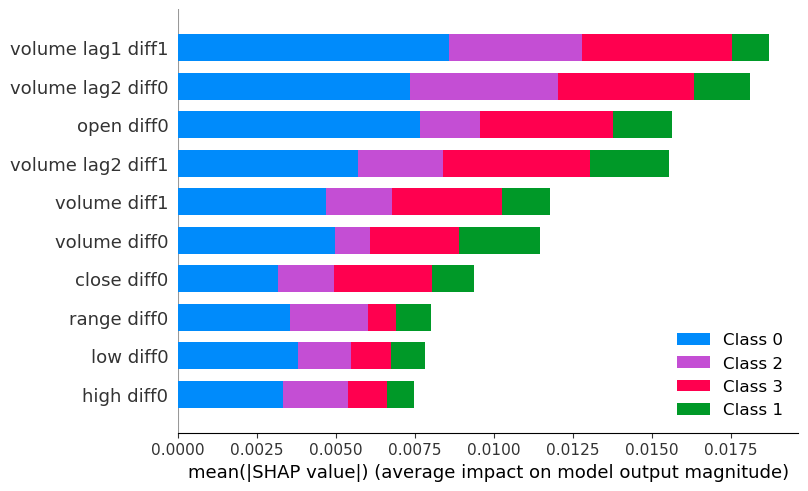

In [50]:

shap.summary_plot(shap_values, X_test_prep, plot_type='bar', max_display=10)


In [64]:


shap.force_plot(explainer.expected_value[0], shap_values[0])
# shap.force_plot(explainer.expected_value, shap_values[0], X_test_prep.iloc[0,:])

In [66]:
print(test_score)

0.21568627450980393


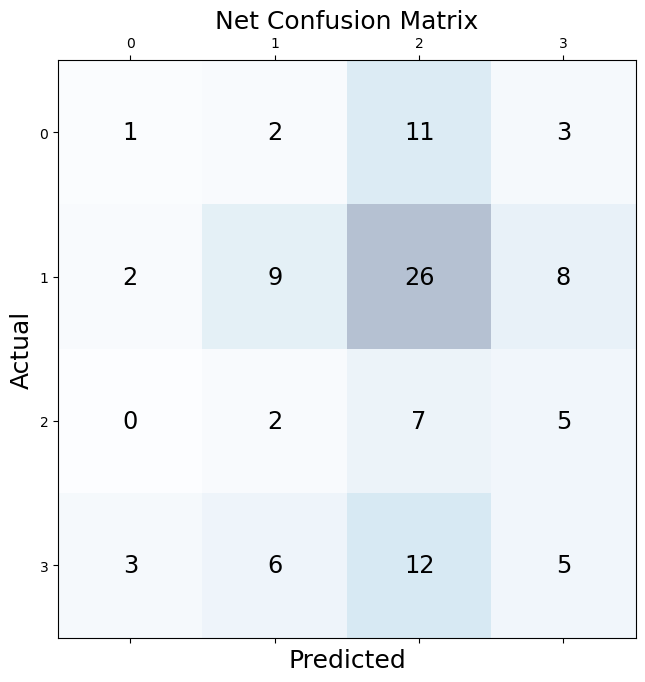

underpric    56
volatile     21
overprice    19
efficient     6
dtype: int64
underpric    168
overprice    128
volatile     112
efficient    103
Name: inefficiency, dtype: int64
overprice    45
volatile     26
efficient    17
underpric    14
Name: inefficiency, dtype: int64


In [73]:
from sklearn.metrics import confusion_matrix




print()
conf_matrix = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
        

plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Net Confusion Matrix', fontsize=18)
plt.show()

print(pd.DataFrame(data=y_test_pred).value_counts())

print(y_other.value_counts())
print(y_test.value_counts())

153


In [165]:
import glob

gr_paths = sorted(glob.glob('../results/multivariate/*'))
results = []
for path in gr_paths:
    file = open(path, 'rb')
    grid = pickle.load(file)
    results.append(grid)
    file.close()
    
xgb_paths = glob.glob('../results/xgboost/*')
xgb_results = []
for path in xgb_paths:
    file = open(path, 'rb')
    grid = pickle.load(file)
    xgb_results.append(grid)
    file.close()

In [166]:
# read in the appropriate range and frequency 
df = pd.read_csv('../data/alpha/MSFT.csv', 
                 parse_dates=['time'], 
                 index_col='time')

df = df[date_range(df)]
df = df.resample(freq).agg(agg_funcs)
# print(df)

# generating the target variable
df = inefficiencies(df, **ineff_params)
# df = df[(df.open > 0) & (df.inefficiency > 'a')] 
# print(df.isnull().sum())

# separating the feature matrix X and target variable y
X = df.iloc[:,:-1].astype({'volume':'float'}) 

y = df.iloc[:,-1]

X_test = X[(df.index > '2022-4-1')&(df.index< '2022-7-1')]
y_test = y[(df.index > '2022-4-1')&(df.index< '2022-7-1')]

X_other = X[(df.index > '2021-1-1')&(df.index< '2022-4-1')]
y_other = y[(df.index > '2021-1-1')&(df.index< '2022-4-1')]


preprocessor = [
    Ranges(),
    Autodifference2(auto_lag=2, diff_lag=2), 
    IterativeImputer(estimator = LinearRegression(), random_state=42, max_iter=500), 
    StandardScaler()
]

pipe = make_pipeline(*preprocessor)

X_other_prep = pd.DataFrame(data=pipe.fit_transform(X_other), columns=new_cols, index=X_other.index)
X_test_prep = pd.DataFrame(data=pipe.transform(X_test), columns=new_cols, index=X_test.index)

gr_best_val_idx = []
model_val_scores = [] 

for i, result in enumerate(results):

        
    bm = result.best_estimator_
    val_score = bm.score(X_other, y_other)
    model_val_scores.append(val_score)
    
        
    if (i+1)%5 == 0:
        
        gr_best_val_idx.append(np.argmax(model_val_scores))
        model_val_scores=[]
        
        print(val_score)

        # print(model.__name__, i, grid.best_params_, grid.best_score_)
        # print(grid.best_estimator_.score(X_test,y_test))
        # print(grid.cv_results_['mean_train_score'])

        

1.0
0.3287671232876712
0.9686888454011742
0.9628180039138943


In [167]:
gr_best_val_idx = np.array(gr_best_val_idx)+np.array([0,5,10,15])

In [168]:
labels = y.unique()
label_map = {key:value for (key,value) in zip(labels, range(len(labels)))}
le = lambda l: label_map[l]

xgb_val_scores = []

print([le(s) for s in y_test])
for result in xgb_results:
    
    xgb_val_scores.append(result.score(X_other_prep, [le(s) for s in y_other]))

xgb_best_val_idx = np.argmax(xgb_val_scores)
        

[3, 3, 2, 2, 2, 2, 3, 0, 0, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 3, 3, 3, 0, 0, 0, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3, 3, 0, 0, 0, 0, 3, 3, 2, 2, 3, 0, 0, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3]


In [169]:
print(xgb_val_scores)

[0.35812133072407043, 0.35812133072407043, 0.35812133072407043, 0.35812133072407043, 0.35812133072407043]


In [180]:
gr_best_models = [results[i].best_estimator_ for i in gr_best_val_idx]
xgb_best_model =  xgb_results[xgb_best_val_idx]

In [181]:
print(gr_best_models)

[Pipeline(steps=[('ranges', Ranges()),
                ('autodifference2', Autodifference2(auto_lag=2, diff_lag=2)),
                ('iterativeimputer',
                 IterativeImputer(estimator=LinearRegression(), max_iter=500,
                                  random_state=42)),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=10, p=1,
                                      weights='distance'))]), Pipeline(steps=[('ranges', Ranges()),
                ('autodifference2', Autodifference2(auto_lag=2, diff_lag=2)),
                ('iterativeimputer',
                 IterativeImputer(estimator=LinearRegression(), max_iter=500,
                                  random_state=42)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.001, l1_ratio=0.1, max_iter=1000000,
                                    penalty='

In [190]:
model_names = []
test_scores = []
models = []
for model in gr_best_models:
    model_names.append(model.steps[-1][0])
    test_scores.append(model.score(X_test, y_test))
    models.append(model)
    
model_names.append('xgboostclassifier')
test_scores.append(xgb_best_model.score(X_test_prep, [le(s) for s in y_test]))
models.append(xgb_best_model)

In [196]:
results_df = pd.DataFrame(data=zip(model_names,models,test_scores), columns=['name', 'model', 'test score'])
results_df = results_df.set_index('name')

In [198]:
results_df[['test score']]

,test score
name,
kneighborsclassifier,0.303922
logisticregression,0.137255
randomforestclassifier,0.225490
svc,0.215686
xgboostclassifier,0.196078


In [202]:
print('baseline:', max(y_other.value_counts().values)/len(y_other))

baseline: 0.3287671232876712


In [207]:
print('baseline:', min(y_test.value_counts().values)/len(y_test))
print('baseline:', y_test.value_counts())

baseline: 0.13725490196078433
baseline: overprice    45
volatile     26
efficient    17
underpric    14
Name: inefficiency, dtype: int64


In [208]:
print('baseline:', max(y_test.value_counts().values)/len(y_test))
print('baseline:', y_test.value_counts())

baseline: 0.4411764705882353
baseline: overprice    45
volatile     26
efficient    17
underpric    14
Name: inefficiency, dtype: int64


In [229]:
import shap

the_model = results_df.model.iloc[np.argmax(results_df['test score'])]
f = lambda x: the_model.predict_proba(x)[:,1]
explainer = shap.Explainer(f, X_other[:100:10])

shap_values = explainer(X_test)

Exact explainer: 103it [00:48,  1.77it/s]                           


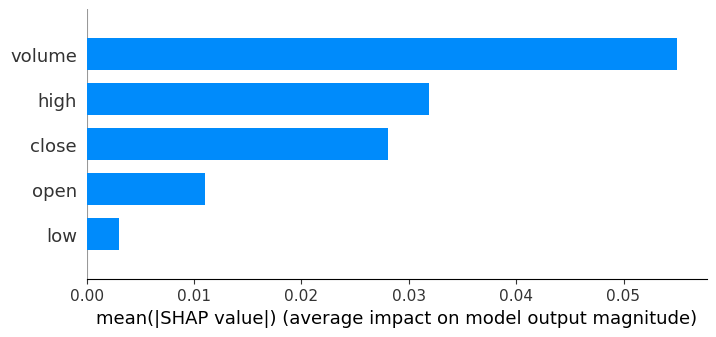

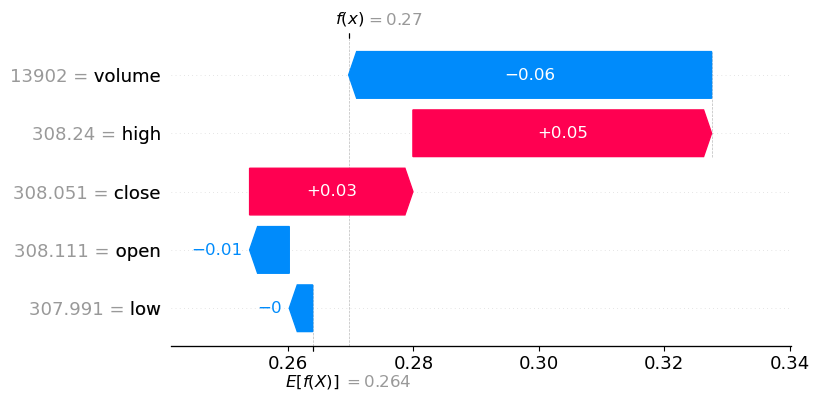

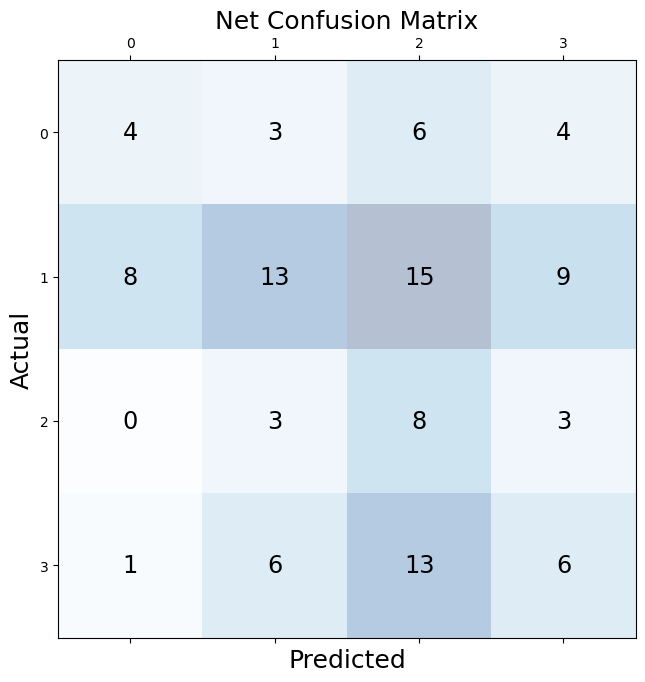

underpric    42
overprice    25
volatile     22
efficient    13
dtype: int64
underpric    168
overprice    128
volatile     112
efficient    103
Name: inefficiency, dtype: int64
overprice    45
volatile     26
efficient    17
underpric    14
Name: inefficiency, dtype: int64


In [243]:
from sklearn.metrics import confusion_matrix

y_test_pred = the_model.predict(X_test)

shap.initjs() # required for visualizations later on

shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=10)
shap.plots.waterfall(shap_values[0])
# shap.force_plot(explainer, shap_values[0])
# shap.force_plot(explainer.expected_value, shap_values[0], X_test_prep.iloc[0,:])


print()
conf_matrix = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
        

plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Net Confusion Matrix', fontsize=18)
plt.show()

print(pd.DataFrame(data=y_test_pred).value_counts())

print(y_other.value_counts())
print(y_test.value_counts())